Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Santosh Dhungana"
ID = "st123415"

---

# Lab 12: Gaussian Mixture Models (GMMs)

In lecture, we learned that the Gaussian Mixture Model (GMM) is a more sophisticated unsupervised clustering method than
$k$-means.

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m
#print(Z, n)

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
   
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]  
       
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [3]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [4]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [5]:
#print(pj)

In [6]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(phi_mse)

[0.21919875 0.57480125 0.206     ]
[0.2, 0.2, 0.6]
0.00023565903963546422


In [7]:
print(Mu)
print(np.array(means_gt).T)

[[ 9.8458599  10.10075802  1.08776031]
 [ 0.9741664   9.97250037  9.84681215]]
[[ 1 10 10]
 [10  1 10]]


In [8]:
print(Sigma)
print(sigmas_gt)

[[[3.87575199 0.19842117]
  [0.19842117 0.88517642]]

 [[0.799153   0.06714473]
  [0.06714473 4.54033756]]

 [[0.82404141 0.01489929]
  [0.01489929 0.84031687]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning
of the experiment. Report your results and briefly discuss in your lab report.

Next, we continue to find outliers:

In [9]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

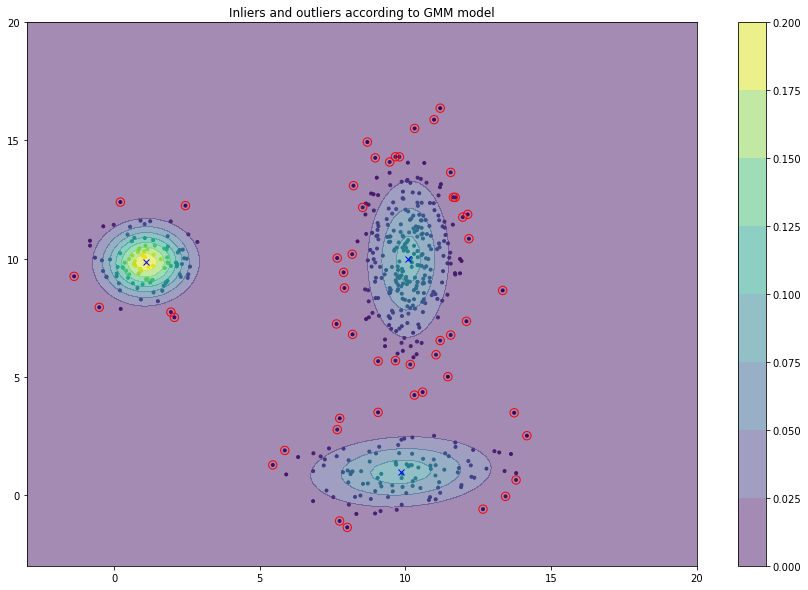

In [10]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, understand why, and explain in your report.  Second, read about Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain in your report. 

## Answer
Broadly, two effects are observed:
 

1. For any arbitary p, different threshold of variance with have different probability densities. Lower sigma (statndard deviation) results in peaked curve while higher sigma yields flat curve leading to more outliers associated with flattened curve despite the same threshold for different clusters.

2. A broad cluster will take in more of the effects from the other clusters from the "w" in comparison to a tight cluster. This is because the likelihood of a datapoint from a different cluster in a tight cluster will have an extremely low value which the likelihood of a datapoint from a different cluster in a broad cluster will have a relatively larger value. Thus further increasing in variance.

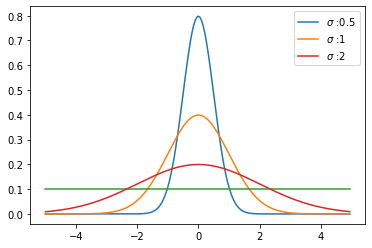

In [11]:
# You may need code to explain
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot between -10 and 10 with .1 steps.
x_axis = np.arange(-5, 5, 0.05)

thresh = np.full((200,), 0.1)
plt.plot(x_axis, norm.pdf(x_axis,0,0.5), label=r'$\sigma$ :0.5') #mean 0, std 1
plt.plot(x_axis, norm.pdf(x_axis,0,1),  label=r'$\sigma$ :1 ') #mean 0, std 1
plt.plot(x_axis, thresh)
plt.plot(x_axis, norm.pdf(x_axis,0,2),  label=r'$\sigma$ :2') #mean 0, std 3
plt.legend()
plt.show()

YOUR ANSWER HERE

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis (5 points)

The Mahalanobis distance (MD) is the measure of distance between a point P and the distribution D. It measures a multi-dimensional measurement of how many $\sigma$  is a point P is from the centriod of D. Distance zero means P coicides with centroid and grows as P moves farther away from D along each principal component axis. 
The formula of Mahalanobis distance is -
\$
D_m(x) = \sqrt{(x-\mu)^T S^\{-1}(x-\mu)}
\$

It is the distance between two points which has been scaled by the eigen vectors and values of the covariance matrix. In essence, it's like transforming all the points so that the distribution becomes a standard normal distributions, then finding the length from the transformed points.

The distance is a better way to find outliers because it aligns correctly with how z-scores work in gaussian distributions.

An interesting thing to note is that the mahalanobis distance is actually a part of the probability function of a multivariate gaussian but unlike the probability function, the mahalanobis distance doesn't have a division by the determinant of the variance.



#### Write code Mahalanobis (10 points)

In [12]:
Sigma[0]

array([[3.87575199, 0.19842117],
       [0.19842117, 0.88517642]])

In [13]:
import sys
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)

m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x- mu).reshape(-1,1)
        # calculate distance from diff and sigma
        # left = np.dot(diff, sig_inv)
        # distance = np.dot(diff, mu.T)
        distance= np.sqrt(diff.T @sig_inv@diff)
        #distance = None
        # YOUR CODE HERE
        #raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.argmin(m_distance), np.unique(m_distance)

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.nonzero(max_z_score < min_distance)[0]
#outlier = np.where(min_distance>max_z_score)
print(outlier)
# YOUR CODE HERE
#raise NotImplementedError()

(3, 2, 2)
(2, 3)
(500, 2)
[ 18  21  32  55  58  72  91 108 113 114 124 126 131 132 147 178 191 204
 205 212 214 221 231 236 238 257 263 265 268 270 271 285 295 308 309 334
 336 337 349 355 366 374 381 382 389 393 397 404 417 425 427 434 438 443
 452 459 467 479 496]


In [14]:
counts

array([ 0.04323173,  0.06086819,  0.09215207, ..., 17.25947825,
       17.387456  , 17.53134589])

outlier [ 18  21  32  55  58  72  91 108 113 114 124 126 131 132 147 178 191 204
 205 212 214 221 231 236 238 257 263 265 268 270 271 285 295 308 309 334
 336 337 349 355 366 374 381 382 389 393 397 404 417 425 427 434 438 443
 452 459 467 479 496]


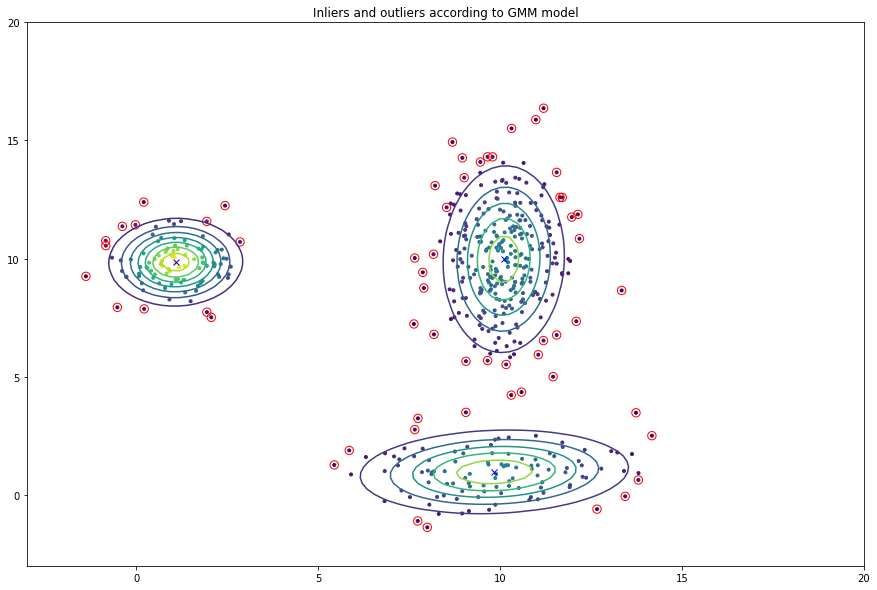

success!


In [15]:
# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation
from last week dataset [Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

Let's stick to just two dimensions in the dataset:

In [16]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [17]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [18]:
print(Mu, Sigma)

[[57.30748786 95.50746042 51.16667812]
 [54.89966578 27.57513023 53.20713398]] [[[ 537.80425841  531.79890707]
  [ 531.79890707  667.79671375]]

 [[ 409.78746373  290.01710856]
  [ 290.01710856  648.00707772]]

 [[ 403.57160965 -376.93061131]
  [-376.93061131  435.07137142]]]


The first row represents annual income, whereas the second row represents the spending score. From what i noticed, these values changes in every iteration, and therefore it is difficult segregate this data into 3 categories.

In [19]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

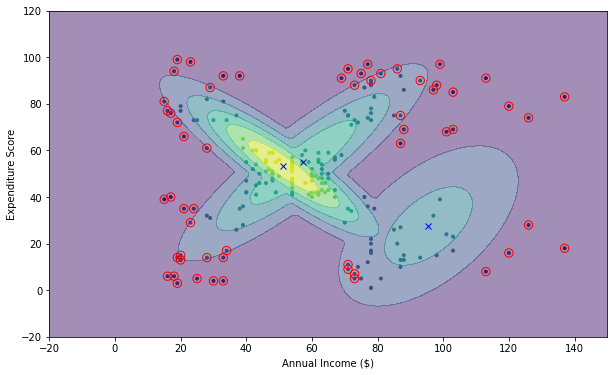

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')
plt.xlabel('Annual Income ($)')
plt.ylabel('Expenditure Score')

plt.show()

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to last week's results with k-means. (20 points)

#### Discussion report (5 points)

YOUR ANSWER HERE

Looking the cluster centers, following could be the inferences could be drawn:
    1. High income people tend to spend less, thouh there are some outliers.
    2. Less income and average income people tend to have similar mean expenditure.

#### Do k-mean and compare the result

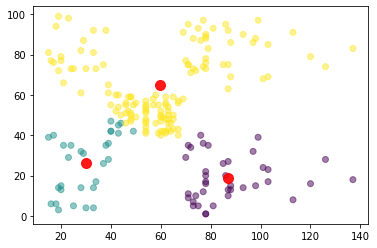

0.0


In [21]:
# YOUR CODE HERE
import numpy as np
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation
import time
import random


# 1. initialize 5 random centers
index= np.arange(X.shape[0])
idx= random.shuffle(index)
k=3
m= X.shape[0]
centers = X[index[0:k], :]

#means= np.zeros((centers.shape))
C=np.zeros(m,dtype=int)
anim_lst =[]
error = 9999999999.0
count=0

#define animation function
while True:
    # 2. find the nearest centers for each of the points
    for i in range(m):
        C[i]= np.argmin(np.linalg.norm(X[i,:] - centers, axis=1))
        # dist= dist+np.linalg.norm(X[i, :]- centers[C[i],:])**2
        # dist=dist/m
    #print(C)
    # 3. plot the graph. Do not forget to use clear_output
    plt.scatter(X[:,0], X[:, 1], c=C, alpha=0.5)
    plt.scatter(centers[:, 0], centers[:, 1], s=100,marker = 'o', c="r", alpha=0.9)
    #plt.savefig("anim_"+str(count) + ".png")
    count+=1
    clear_output(wait=True)
    plt.show()
    #clear_output()
    # 4. find the mean of each centers
    means= centers.copy()
    for j in range(centers.shape[0]):
        means[j, :]= np.mean(X[np.where(C == j)],axis = 0)
    # 5. calculate sum square error to check error. If the error is less than 1e-6, you can stop the loop.
    
    error = ((means - centers)**2).sum()
    print(error)
    if error < 1e-6:
        break
    else:
        centers= means
        anim_lst.append(centers)
    #count+=1
    time.sleep(0.3)
#raise NotImplementedError()

K-means was used to cluster data into 3 clusters as former example. It is able seperate the data into 3 clusters and locate their centers, however, it is not able to identify outliers in the clusters. Outliers tends to skew the centroids leading to inaccurate clusters.

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [22]:
outlier = 0.01
k=3
# YOUR CODE HERE
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.05  
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)
# raise NotImplementedError()

outlier (array([  0,   4,  11,  16,  17,  19,  22,  30,  32,  33,  41, 123, 127,
       145, 189, 193, 198, 199]),)


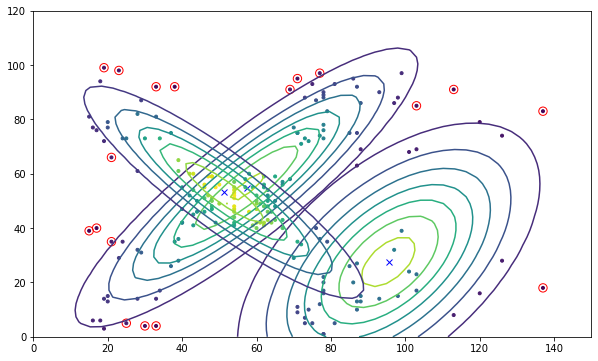

success!


In [23]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

### Example 3 Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [24]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [25]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [26]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [27]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [28]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


In [29]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [30]:
Mu = np.std(data[numerical_colmns])
Sigma = np.mean(data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64
Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64


In [31]:
Mu

Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64

In [32]:
# Check for outliers

def cnt_outlier(data,sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma**2
    return outlier.sum()

cnt_outlier(data,Sigma,Mu, numerical_colmns).sort_values(ascending=False)

Quantity     4650
UnitPrice      56
TotalSum       12
dtype: int64

In [33]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


In [34]:
Q1 = data.quantile(0.1) #removing the outliers completely beyond the 0.1 and 0.8 percentile for simplicity
Q3 = data.quantile(0.9)

#we only take data within the Quartiles
data_new = data[~((data < (Q1)) |(data > (Q3))).any(axis=1)]

In [35]:
Mu = np.mean(data_new[numerical_colmns])
Sigma = np.std(data_new[numerical_colmns])
print(Mu)
print(Sigma)

Quantity      6.161570
UnitPrice     2.518726
TotalSum     11.950464
dtype: float64
Quantity     5.799214
UnitPrice    1.496868
TotalSum     9.678009
dtype: float64


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [36]:
X = data_new.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[-1.40652854  0.66188805 -0.98034791 -0.37994392         nan  0.7800712 ]
 [-1.40327849  0.66188805 -0.98034791 -0.37994392         nan  0.7800712 ]
 [-1.40002844  0.66188805 -0.98034791  0.28811778         nan  1.81334155]
 ...
 [ 0.84250446 -0.71760934  1.75764867 -0.71397478         nan -0.9351576 ]
 [-0.74676886 -0.89004652  1.75764867  0.28811778         nan -0.92999125]
 [-1.14002463 -0.02786064  1.75764867  1.6242412          nan  1.83400696]]


In [37]:
# Your code here
X_1= X[:, [1,5]]# quantity vs total sum
X_1.shape

(1962, 2)

In [38]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    np.random.seed(40)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma



def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

In [39]:
threshold = np.matrix(.01)
k=3
Phi, Mu, Sigma = init_gmm(X_1, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X_1, threshold, Phi, Mu, Sigma)

In [40]:
Phi, Mu, Sigma

(array([0.27482695, 0.3317448 , 0.39342825]),
 array([[-0.36777896, -0.82920746,  0.95611037],
        [-0.09562328, -0.89921887,  0.82503235]]),
 array([[[0.07564827, 0.05146298],
         [0.05146298, 0.28339551]],
 
        [[0.00872664, 0.00350699],
         [0.00350699, 0.02136565]],
 
        [[0.89314202, 0.29715763],
         [0.29715763, 0.9568942 ]]]))

In [41]:
print(Mu.shape)
m_distance = np.zeros((X_1.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X_1):
        # get all row data from target column
        mu = Mu[:,kk]
        # get target sigma
        sig = Sigma[kk,:,:]
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(-1,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(np.dot(np.dot(diff.T, sig_inv),diff))
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = np.unique(np.argmin(m_distance,axis=1)), len(np.unique(np.argmin(m_distance,axis=1)))

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis=1)
# find outlier from min_distance
outlier = np.where(min_distance > max_z_score)
print(outlier)

(2, 3)
(array([   4,   13,   17,   18,   50,   71,   72,   91,   92,   94,  139,
        159,  167,  332,  334,  337,  353,  364,  370,  379,  538,  550,
        613,  653,  654,  655,  656,  657,  658,  674,  701,  717,  742,
        784,  785,  789,  791,  792,  793,  794,  795,  796,  797,  798,
        832,  833,  883,  892,  938,  942,  946,  947,  948,  949,  950,
        951,  952,  953,  973,  977,  978,  979,  990,  991, 1038, 1076,
       1118, 1119, 1120, 1121, 1132, 1164, 1165, 1166, 1167, 1168, 1169,
       1177, 1179, 1180, 1212, 1242, 1317, 1320, 1327, 1343, 1344, 1413,
       1424, 1425, 1436, 1437, 1438, 1440, 1441, 1483, 1484, 1487, 1514,
       1516, 1521, 1566, 1584, 1585, 1638, 1640, 1641, 1647, 1677, 1737,
       1738, 1739, 1740, 1741, 1785, 1787, 1798, 1806, 1818, 1819, 1820,
       1821, 1822, 1829, 1847, 1848, 1870, 1871, 1890]),)


(1962, 2)


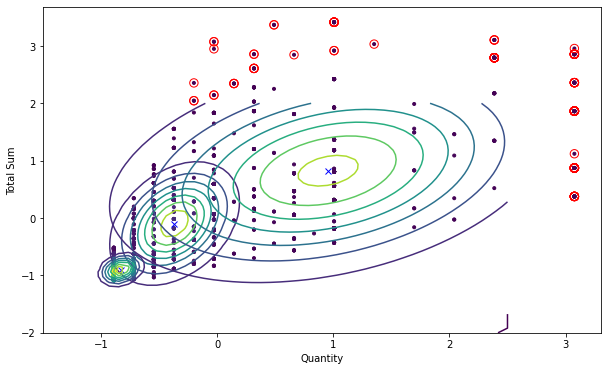

In [42]:
print(X_1.shape)
# Test function: Do not remove
# print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X_1[:,0],X_1[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X_1[outlier,0],X_1[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx', )

for c in np.arange(0,k):    
    X_class = X_1[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(-1.5, 2.5, 50)
    ylist = np.linspace(-2, 2, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
#             print("pt", pt)
#             print("mu", Mu[:2,c])
#             print(Sigma)
            Z[i,j] = Gaussian(pt, Mu[:2,c], Sigma[c])
            j = j + 1
        i = i + 1    
        
    cp = plt.contour(XX, YY, Z)
# plt.xlim(-2,2)
# plt.ylim(-3,5)
plt.xlabel('Quantity')
plt.ylabel('Total Sum')
plt.show()
# End test function

Initially, with the processed original data, the gmm was unable to converge for the quanity and total sum.Then the data was curtailed by setting lower and upper limit of 0.1 and 0.9. Convergence of GMM was achieved but sitll outliers were too spread. Further, cluster 2 adn cluster3 have higher overlap.

In [43]:
def cost(X_label, Mu):
    loss = np.inf
    for j in range(Mu.shape[1]) : 
        Muj = Mu.T[j]
        Xj = X_label[X_label[:, -1] == j][:, :-1]
        loss = min(loss, np.min(np.linalg.norm(Xj-Muj)))
    return loss

likelihood = []
for k in range(1,4):
    threshold = np.matrix(.01)

    Phi, Mu, Sigma = init_gmm(X_1, k)

    converged = False
    while not converged:
        converged, pj, X_label = iterate_em_gmm(X_1, threshold, Phi, Mu, Sigma)
    loss = cost(X_label, Mu)
    likelihood.append(loss)

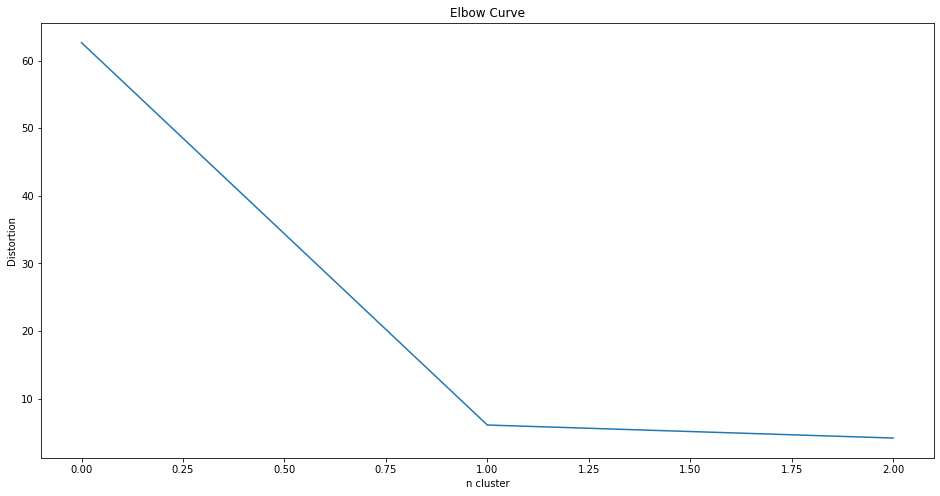

In [44]:
likelihood = np.array(likelihood)
plt.figure(figsize=(16,8))
plt.plot(likelihood)
plt.xlabel('n cluster')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

In [45]:
likelihood

array([62.64183905,  6.09815776,  4.17385414])

Based on elbow curve, the optimum cluster seem to break at k=1. Considering the major overlap between all the cluster, n=1 seems to be okay.